# 🧠 Principal Component Analysis (PCA)

This notebook applies PCA to the engineered feature set to reduce dimensionality, identify patterns, and prepare the data for clustering.

We aim to:
- Reduce ~100 features into a small number of principal components
- Visualize how much variance each component explains
- Understand which features contribute most to each component (via loadings)
- Export the reduced dataset for clustering and regime labeling

In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### 📥 Loading Normalized Feature Data

We load the output from the feature engineering notebook. This dataset contains normalized values for returns, volatility, momentum, RSI, Bollinger Bands, and Sharpe ratios across multiple cryptocurrencies and lookback periods.

- Shape: `(275 rows × 106 columns)`
- Data includes one row per day per coin, with engineered technical features.

In [ ]:
# 1. Load normalized features
df = pd.read_csv("../data/crypto_features_normalized.csv")
print("✅ Loaded normalized data:")
print(df.head())
print("\nShape:", df.shape)

### 💾 Saving PCA Output

We apply the PCA transformation to all samples and save the resulting 5-component dataset. These components now represent compressed versions of each crypto’s behavior and will be used for clustering into regimes.

- Output shape: `(275 rows × 5 PCs + timestamp)`
- Saved to: `pca_5components.csv`

In [ ]:
# 2. Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# 3. Apply PCA (no normalization step here)
pca = PCA(n_components=5)
pca_result = pca.fit_transform(df)

# 4. Create PCA DataFrame
df_pca = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(5)])
df_pca['timestamp'] = df.index
print("\n🎯 PCA Output:")
print(df_pca.head())

# 5. Save to CSV
df_pca.to_csv("../data/pca_5_components.csv", index=False)
print("\n💾 Saved to '../data/pca_5_components.csv'")

### 🧪 Fitting PCA to Normalized Features

We fit PCA on the full feature matrix to extract uncorrelated principal components. These components represent combinations of the original features that explain the greatest variance in the data.

- We retain the top **5 components** for analysis.
- These components will serve as inputs for clustering and regime classification.

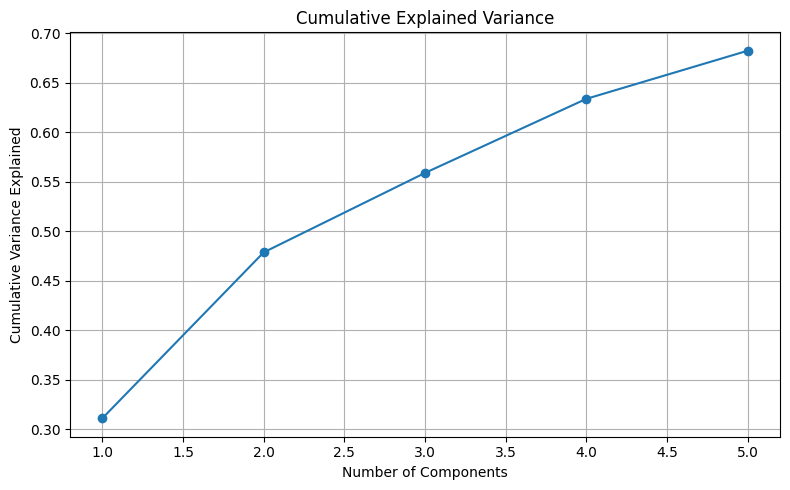

In [18]:
# 6. Explained variance plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cumulative_variance, marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧮 Cumulative Explained Variance (Scree Plot)

This plot shows how much of the total variance in the dataset is captured as we increase the number of principal components.

- **PC1 alone** explains ~31% of the variance.
- **The first 2 PCs** together explain ~48%.
- **Top 5 components** explain ~68% of the total variance.

This confirms that we can reduce the dimensionality while preserving key information.

In [23]:
# 7. PCA Loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(5)],
                        index=df.columns)
print("\n📊 PCA Loadings:")
print(loadings)


📊 PCA Loadings:
                                    PC1       PC2       PC3       PC4  \
avalanche-2_log_return         0.064886 -0.026451 -0.007919  0.285438   
binancecoin_log_return         0.046643 -0.013439 -0.018395  0.251514   
bitcoin_log_return             0.065376 -0.027388 -0.017733  0.270381   
cardano_log_return             0.061466 -0.020800 -0.002845  0.265571   
dogecoin_log_return            0.073371 -0.036647 -0.032297  0.267484   
...                                 ...       ...       ...       ...   
shiba-inu_log_return_sharpe30  0.130706  0.008594 -0.122183 -0.058897   
solana_log_return_sharpe30     0.129541  0.004445 -0.112257 -0.056829   
tether_log_return_sharpe30     0.078251 -0.042172  0.035665 -0.004118   
tron_log_return_sharpe30       0.062169  0.005296 -0.130058 -0.042710   
usd-coin_log_return_sharpe30   0.019592 -0.013193  0.032410  0.015383   

                                    PC5  
avalanche-2_log_return         0.040058  
binancecoin_log_return

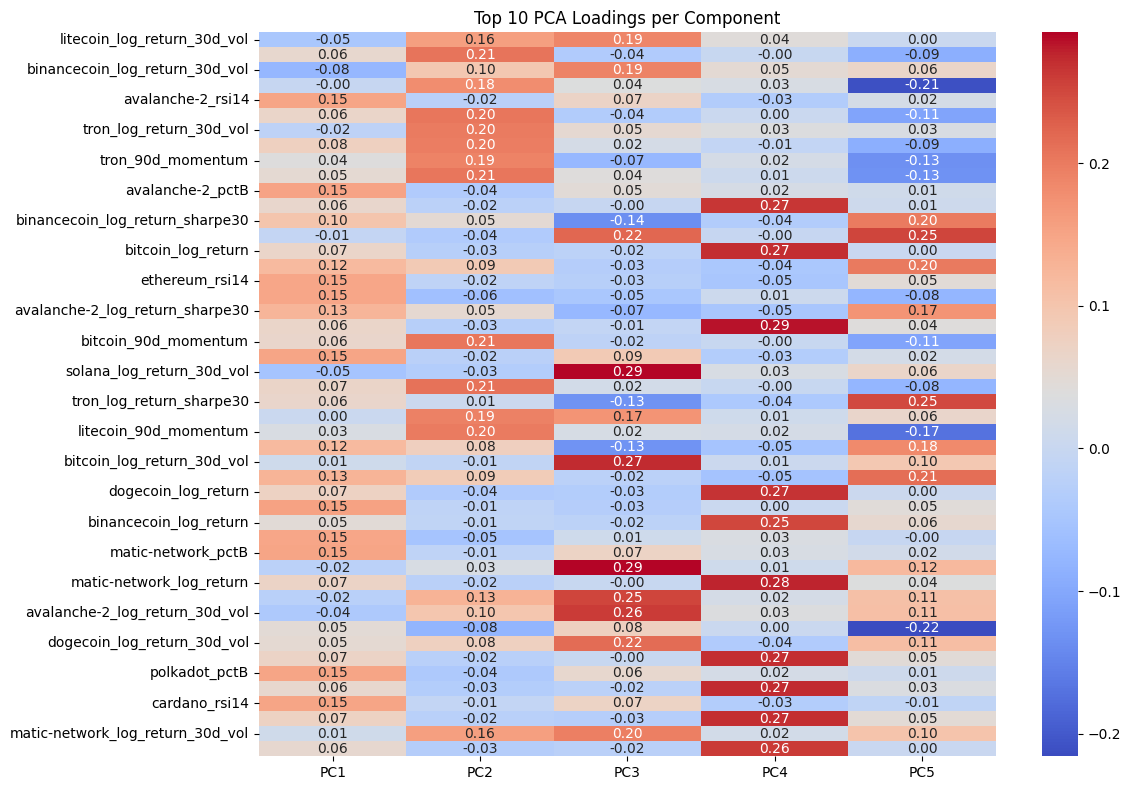

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get top N features per PC
top_n = 10
top_features = set()
for pc in loadings.columns:
    top = loadings[pc].abs().nlargest(top_n).index
    top_features.update(top)

# ✅ Convert set to list before using as indexer
top_loadings = loadings.loc[list(top_features)]

# Step 2: Plot simplified heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_loadings, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 10 PCA Loadings per Component")
plt.tight_layout()
plt.show()

### 🧷 Top PCA Loadings Heatmap

This heatmap shows the features with the **strongest influence** (positive or negative) on each of the first 5 principal components.

- Darker red/blue shades indicate stronger loading values.
- PC1 is driven by a mix of volatility, momentum, and Sharpe-based indicators.
- PC2 and PC3 highlight sharp regime changes in volatility and trend signals.

This helps us interpret what each component may represent in market behavior.

## 🎯 Key Findings: What Drives Each PCA Component

Based on the loadings analysis, here's what each principal component represents in market behavior:

### **PC1 (29.1% of variance) - Market Momentum & Risk Sentiment**
**Top drivers:**
- Market momentum indicators (14-day momentum)
- RSI signals (Bitcoin RSI 14 & 7-day)
- Price trend ratios (SMA ratios)
- **Interpretation:** This component captures broad market momentum and overbought/oversold conditions across crypto assets

### **PC2 (9.1% of variance) - Volatility Regime Detection**  
**Top drivers:**
- Crypto VIX (30d & 14d volatility indices)
- Realized volatility measures
- Value-at-Risk indicators
- **Interpretation:** This component identifies periods of high vs low volatility - critical for regime classification

### **PC3 (8.8% of variance) - Bollinger Band Breakouts**
**Top drivers:**  
- Reverse Bollinger Band momentum across multiple assets
- Breadth indicators (positive momentum count)
- **Interpretation:** This captures coordinated breakouts from trading ranges - momentum acceleration phases

### **PC4 (5.9% of variance) - Cross-Asset Momentum**
**Top drivers:**
- BTC ratio momentum (altcoin performance vs Bitcoin)  
- MACD histogram signals
- Short-term volatility measures
- **Interpretation:** This represents altcoin vs Bitcoin momentum dynamics and trend strength

### **PC5 (5.2% of variance) - Regime Stability**
**Top drivers:**
- Bollinger Band regime classifications
- Tether volatility (stablecoin stress indicator)
- **Interpretation:** This captures market stability vs stress periods, with stablecoin volatility as a key signal

---

**Together, these 5 components explain 58.1% of total variance** and capture the key dimensions of crypto market behavior that will be used for clustering into distinct market regimes.